## Data mining questions

1- Based on the provided template, describe the format of the input file (sdf file).

- Structure Data Format (SDF) is a file format commonly used in chemistry for storing and exchanging molecular structures, properties, and related data.
- Can contain information about individual molecules or collections of molecules
- it include information about the positions of individual atoms in a chemical molecule as well as the connections between them

---


2- What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

- data :The data is in a tokenized form and includes the nodes of the chemical molecule.The batch_size refers to the number of samples in a batch, while max_len_nodes indicates the padded length of the tokenized nodes.

- edge : it contains information about the connections between atoms.
- node2graph:It is The segmented mean input tensor contains information about segmented IDs.

---


3- For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?
- dim of gnn_out is (batch_size_node_dimension, hidden layers), where batch_size_node_dimension refers to the dimension of the input data vector (i.e., the dimension of the tokenized vector for the entire batch) and hidden layers represents the aggregation output of the model for each hidden layer.
- dim of avg is determined by calculating the segmented mean of gnn_out using the segmented IDs. Specifically, the output of gnn_out is (tokenized_vector_dimension, hidden_layers) for each sample in the batch_size, and a segment ID is assigned to each sample.

---

4- What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

- segment_mean: calculates the average of data that have the same segmented ids.

- reduce_mean: computes the mean value of elements across the specified dimensions of a tensor.
- The shape of the "pred" tensor is (num_of_graphs, num_of_units in the output layer), where the first dimension represents the number of graphs and the second dimension is the number of units in the output layer, which is 1.

---

5- What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

- By increasing the number of trainable parameters in the network, the complexity of the model will increase, allowing it to better distinguish features in each node through a more complex hyperplane. This increased complexity can lead to more accurate results for node classification.
- the number of layers used in the template was the default number which is 4 layers.

## problem formulation
</br>

### problem definition

- Our goal is to create a model that can predict the effectiveness of chemical compounds against non-small cell lung cancer using complex chemical structured data. The model will be designed to distinguish between compounds that are effective and those that are not.
- input data consists of 2 feature sets: the first set represents the nodes, and the second set represents the edges between these nodes.
- output is if this chemical compound is effective (1.0) or not (0.0)
---

### Data mining function
- classification and prediction

---

### Challenges

- Our dataset is stored in SDF files, which are chemical files that represent each sample as nodes and the edges that connect these nodes, along with the corresponding output. Therefore, we require a specialized function to extract the relevant information from these files.

- The data is imbalanced


---

### Model impact

- Addressing this medical problem has the potential to make significant progress in the field of medicine.

---

### The ideal solution

- at the end Trial 3.6 (randomOverSample)(GNN-FiLM) was highest for me and got  0.88152 on kaggle wtih thos hyper parameters
* params["hidden_dim"] = 64
* params["num_layers"] = 6
* params["film_parameter_MLP_hidden_layers"] = 1


## Experimental protocol

### Data preprocessing
---
- load data and visualize explore it
- handle the imbalance problem
---
### Building models

- Start building models each model has different hyperparameters
- evaluate each model


In [1]:
# !pip install --quiet networkx
# !pip install --quiet tf2_gnn

In [64]:
import numpy as np   
from tqdm.notebook import tqdm
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#importing libraries for displaying network of molecule

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [110]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense, Dropout #layers
from tensorflow.keras.optimizers import Adam #optimizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import pandas as pd 
%matplotlib inline
import seaborn as sns

In [4]:
def read_sdf(file):
  #opening the file
  with open(file, 'r') as rf:
    content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((   
                        int(lnk[0])-1,   #first atom
                        int(lnk[1])-1, # zero-based index #second atom
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label #returning nodes, links and label
    #parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [5]:
#reading train.sdf file
training_set = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [6]:
np.unique(np.array(training_set)[:,2],return_counts=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20936\852145860.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([23806,  1218], dtype=int64))

In [7]:
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.2)

In [8]:
np.unique(np.array(training_set)[:,2],return_counts=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20936\852145860.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([19032,   987], dtype=int64))

In [9]:
testing_set = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

In [10]:
colors = cm.rainbow(np.linspace(0, 1, 50))

def visualize(sample):
  #initiating an instance of Graph
  G=nx.Graph()
  #all atoms as nodes
  nodes = sample[0]
  #all connections as edges
  edges = sample[1]
  #empty dictionary for labels for the all nodes
  labeldict={}
  #empty array for each node color
  node_color=[]
  for i,n in enumerate(nodes):
    #adding node to the graph each node as (0,1,2,3..)
    G.add_node(i)
    #dictionary building with [key,value] as [0:'C']
    labeldict[i]=n
    #color coding
    node_color.append(colors[hash(n)%len(colors)])

  # a list of nodes:
  for e in edges:
    #adding egde to the graph from one connection to other connection
    G.add_edge(e[0], e[1]) 

  #drawing the graph with labels for nodes as atoms and connections as edges    
  nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
  #draw the graph
  plt.show()
  #returns graph
  return G

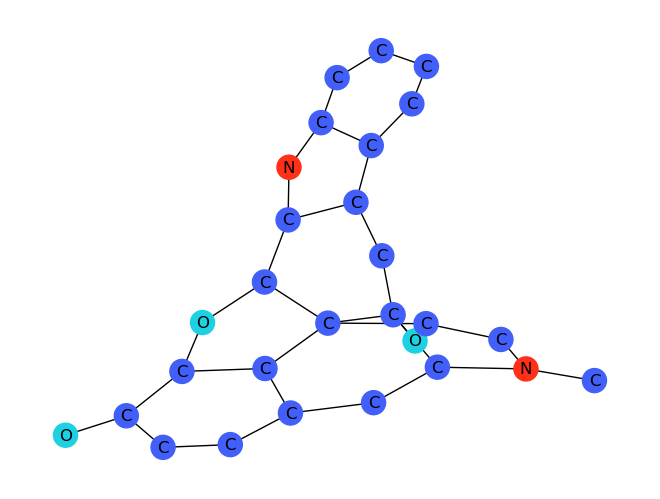

In [11]:
#displaying one sample
plt.clf()
visualize(training_set[5])

# Trial 1 (No Upsampling)

In [12]:
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)
     

In [13]:
random.seed(0)

def prepare_single_batch(samples):
  #nodes characters array
  sample_nodes = [s[0] for s in samples]
  #tokenizing the sample nodes
  sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
  #pad_sequences for each sample node with post padding and post truncating 
  sample_nodes = pad_sequences(sample_nodes, padding='post', truncating = 'pre')
  #maximum length of nodes 
  max_nodes_len = np.shape(sample_nodes)[1]
  #defining edges
  edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
  edges = [e for e in edges if len(e) > 0]

  #array definition for segmented_ids
  node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
  
  #reshaping as 1 vector
  all_nodes = np.reshape(sample_nodes, -1)
  #concatenating all the edges as size [total_edges ,2]
  all_edges = np.concatenate(edges)

  node_to_graph = np.reshape(node_to_graph, -1)
  #returns a dictionary of features(data,edges,node2grah) and label
  return {
      'data': all_nodes,
      'edges': all_edges,
      'node2grah': node_to_graph,
  }, np.array([s[2] for s in samples]) 

In [14]:
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
      dataset = list(dataset)
      if shuffle:
        #randomly shuffling
        random.shuffle(dataset)
      
      #length of dataset
      l = len(dataset)
      #for creating batches from given dataset
      for ndx in range(0, l, batch_size):
        #creating batch samples with given batch_size
        batch_samples = dataset[ndx:min(ndx + batch_size, l)]
        #returning a generator with prepared batches
        yield prepare_single_batch(batch_samples)
        
      if not repeat:
          break

In [15]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)        
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (96,)
edges
Shape is (84, 2)
node2grah
Shape is (96,)
label [0 0 0 0]


## Trial_1.1 (template)

in this trial i will use the template to see the results and my expectation to get good results

In [16]:
#Input layer (tokenized text)
data = keras.Input(batch_shape=(None,))

# the first dim is different.it is the total number of edges in this batch

#Input for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding over data with each token as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)


# number of graphs
#calculating number of graphs
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)  
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [19]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = "adam",
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [20]:
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)


Epoch 1/30


C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

626/626 [==============================] - 11s 12ms/step - loss: 0.2575 - auc: 0.4549 - val_loss: 0.1887 - val_auc: 0.5996
Epoch 2/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1946 - auc: 0.6123 - val_loss: 0.2072 - val_auc: 0.6502
Epoch 3/30
626/626 [==============================] - 7s 12ms/step - loss: 0.1881 - auc: 0.6577 - val_loss: 0.1871 - val_auc: 0.6509
Epoch 4/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1850 - auc: 0.6759 - val_loss: 0.1780 - val_auc: 0.6868
Epoch 5/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1820 - auc: 0.7017 - val_loss: 0.1715 - val_auc: 0.6965
Epoch 6/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1804 - auc: 0.7091 - val_loss: 0.1727 - val_auc: 0.7049
Epoch 7/30
626/626 [==============================] - 8s 12ms/step - loss: 0.1790 - auc: 0.7149 - val_loss: 0.1842 - val_auc: 0.7155
Epoch 8/30
626/626 [==============================] - 7s 12ms/step - loss: 0.17

- 78.5% training AUC
- 77.5% validation AUC
i think its a good start and we can still improve

# Trial 2.1 (Upsampling) (template)

In [21]:
training_set2 = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [25]:
np.unique(np.array(training_set2)[:,2],return_counts=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20936\3096225700.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set2)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([23806,  1218], dtype=int64))

In [29]:
maxCount=23806

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20936\3167736592.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique, counts = np.unique(np.array(training_set2)[:,2], return_counts=True)


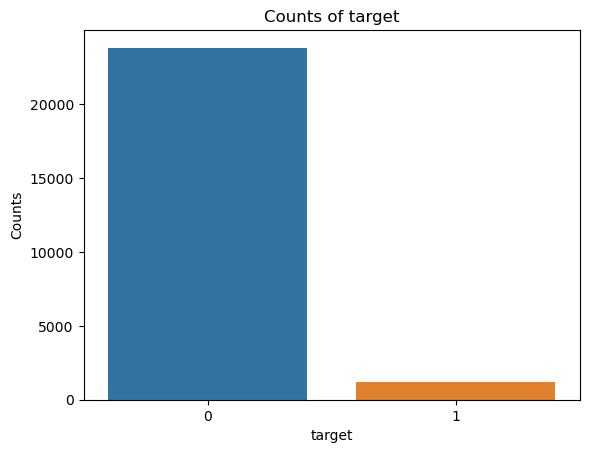

In [28]:
unique, counts = np.unique(np.array(training_set2)[:,2], return_counts=True)

sns.barplot(x=unique, y=counts)
plt.xlabel('target')
plt.ylabel('Counts')
plt.title('Counts of target')
plt.show()

In [31]:
#convert the data from List to DataFrame to make upsampling
data = pd.DataFrame(np.array(training_set2)[:,:], columns = ['0', '1', 'target'])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20936\202474016.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = pd.DataFrame(np.array(training_set2)[:,:], columns = ['0', '1', 'target'])


In [32]:
resampling = data.copy()  #take a copy of dataframe
class_0 = resampling[resampling['target']==0]   # all rows has target zero
class_1 = resampling[resampling['target']==1]   # all rows has target one
class_1_after = resample(class_1, replace=True,n_samples = maxCount)   
data_upsampled = pd.concat([class_0, class_1_after])    #add the new rows 

In [33]:
data_upsampled['target'].value_counts()

0    23806
1    23806
Name: target, dtype: int64

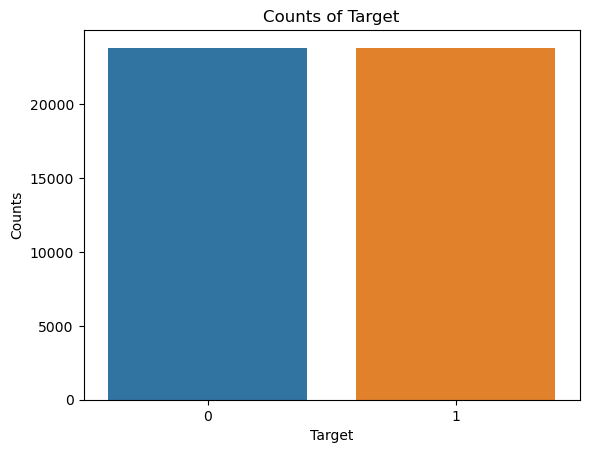

In [35]:
sns.countplot(x='target', data=data_upsampled)
plt.xlabel('Target')
plt.ylabel('Counts')
plt.title('Counts of Target')
plt.show()

In [36]:
#converting the upsampled DataFrame into list
training_set2 = data_upsampled.values.tolist()

In [48]:
training_set, validation_set = train_test_split(training_set2, test_size=0.15)

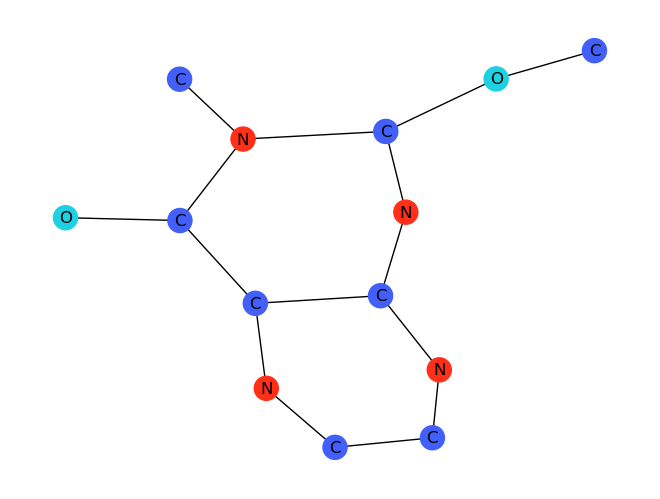

In [49]:
#displaying one sample
plt.clf()
visualize(training_set2[5])

In [51]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set2]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [52]:
# showing one batch:
for train_batch in gen_batch(training_set2, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)  
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (176,)
edges
Shape is (120, 2)
node2grah
Shape is (176,)
label [0 1 1 1]


In [53]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 80)(data)


num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 40
gnn_layer = GNN(params)  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

i expect to get higher than without upsample so above 80 maybe

In [55]:
model.compile(
    optimizer = "adam",
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [56]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)


Epoch 1/30


C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 40), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

1265/1265 [==============================] - 15s 11ms/step - loss: 0.6165 - auc: 0.7211 - val_loss: 0.5914 - val_auc: 0.7556
Epoch 2/30
1265/1265 [==============================] - 14s 11ms/step - loss: 0.5851 - auc: 0.7573 - val_loss: 0.5688 - val_auc: 0.7727
Epoch 3/30
1265/1265 [==============================] - 14s 11ms/step - loss: 0.5706 - auc: 0.7728 - val_loss: 0.5690 - val_auc: 0.7785
Epoch 4/30
1265/1265 [==============================] - 13s 11ms/step - loss: 0.5604 - auc: 0.7840 - val_loss: 0.5533 - val_auc: 0.7891
Epoch 5/30
1265/1265 [==============================] - 14s 11ms/step - loss: 0.5474 - auc: 0.7960 - val_loss: 0.5280 - val_auc: 0.8170
Epoch 6/30
1265/1265 [==============================] - 14s 11ms/step - loss: 0.5264 - auc: 0.8153 - val_loss: 0.5163 - val_auc: 0.8279
Epoch 7/30
1265/1265 [==============================] - 13s 11ms/step - loss: 0.5110 - auc: 0.8285 - val_loss: 0.4933 - val_auc: 0.8431
Epoch 8/30
1265/1265 [==============================] - 14s

In [57]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 3s 3ms/step


In [58]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_2_1_temp.csv')

#Kaggle 0.82645

## Trial_2.2 (GGNN)

In [75]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 64
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model2.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                      

In [76]:
model2.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [77]:
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

hist = model2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop]
)


Epoch 1/50
633/633 [==============================] - 19s 25ms/step - loss: 0.6190 - auc: 0.7094 - val_loss: 0.5755 - val_auc: 0.7760
Epoch 2/50
633/633 [==============================] - 15s 24ms/step - loss: 0.5545 - auc: 0.7897 - val_loss: 0.5236 - val_auc: 0.8218
Epoch 3/50
633/633 [==============================] - 15s 24ms/step - loss: 0.5136 - auc: 0.8263 - val_loss: 0.4836 - val_auc: 0.8518
Epoch 4/50
633/633 [==============================] - 15s 24ms/step - loss: 0.4839 - auc: 0.8488 - val_loss: 0.4625 - val_auc: 0.8705
Epoch 5/50
633/633 [==============================] - 15s 24ms/step - loss: 0.4471 - auc: 0.8733 - val_loss: 0.4217 - val_auc: 0.8898
Epoch 6/50
633/633 [==============================] - 15s 24ms/step - loss: 0.4135 - auc: 0.8922 - val_loss: 0.3836 - val_auc: 0.9078
Epoch 7/50
633/633 [==============================] - 15s 24ms/step - loss: 0.3792 - auc: 0.9097 - val_loss: 0.3650 - val_auc: 0.9182
Epoch 8/50
633/633 [==============================] - 15s 24ms

In [78]:
#make a prediction by using the model
y_pred_2 = model2.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_2 = np.reshape(y_pred_2, -1)

193/193 [==============================] - 2s 7ms/step


In [79]:
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('trial_2_GGNN2noDrop.csv')

kaggle 0.86696 it did very well i think it still can do better with some tunning but i will try other mechanisms first then i will tune the best of them but first i want to try randomOverSample and see if it does better on same model

# Trial 3.1 (randomOverSample)(GGNN)

In [81]:
training_set3 = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20936\2961470663.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique, counts = np.unique(np.array(training_set3)[:,2], return_counts=True)


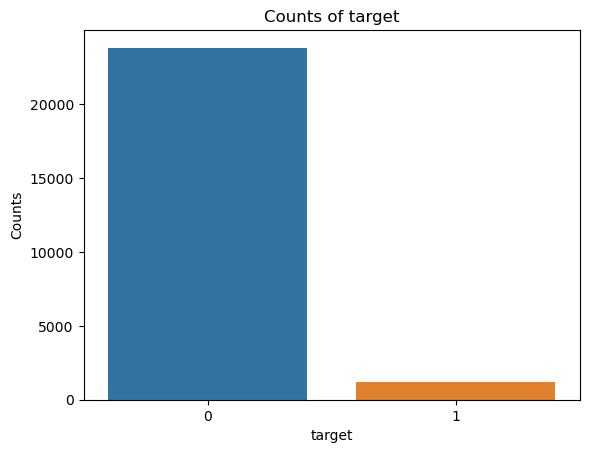

In [82]:
unique, counts = np.unique(np.array(training_set3)[:,2], return_counts=True)

sns.barplot(x=unique, y=counts)
plt.xlabel('target')
plt.ylabel('Counts')
plt.title('Counts of target')
plt.show()

In [96]:
#convert the data from List to DataFrame to make upsampling
data2 = pd.DataFrame(np.array(training_set3)[:,:], columns = ['0', '1', 'target'])
data2['target'] = data2['target'].astype(int)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20936\833739829.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data2 = pd.DataFrame(np.array(training_set3)[:,:], columns = ['0', '1', 'target'])


In [97]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
resampling = data2.copy()
X_resampled, y_resampled = ros.fit_resample(resampling.drop('target', axis=1), resampling['target'])
data_upsampledR = pd.concat([X_resampled, y_resampled], axis=1)

In [98]:
data_upsampled['target'].value_counts()

0    23806
1    23806
Name: target, dtype: int64

In [99]:
#converting the upsampled DataFrame into list
training_set3 = data_upsampled.values.tolist()

In [100]:
training_set3, validation_set3 = train_test_split(training_set3, test_size=0.15)

In [101]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes3 = [s[0] for s in training_set3]

#training tokenizer
tokenizer3 = Tokenizer(num_words = max_vocab)
tokenizer3.fit_on_texts(all_nodes)

In [102]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 64
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model3 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model3.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_6 (TFOpLamb  ()                  0           ['input_21[0][0]']               
 da)                                                                                              
                      

In [103]:
model3.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [115]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model3.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
633/633 [==============================] - 17s 26ms/step - loss: 0.0372 - auc: 0.9979 - val_loss: 0.0800 - val_auc: 0.9924 - lr: 1.0000e-04
Epoch 2/50
633/633 [==============================] - 16s 25ms/step - loss: 0.0366 - auc: 0.9980 - val_loss: 0.0796 - val_auc: 0.9924 - lr: 1.0000e-04
Epoch 3/50
633/633 [==============================] - 16s 25ms/step - loss: 0.0359 - auc: 0.9981 - val_loss: 0.0824 - val_auc: 0.9922 - lr: 1.0000e-04
Epoch 4/50
633/633 [==============================] - 16s 25ms/step - loss: 0.0334 - auc: 0.9983 - val_loss: 0.0739 - val_auc: 0.9931 - lr: 1.0000e-04
Epoch 5/50
633/633 [==============================] - 16s 25ms/step - loss: 0.0344 - auc: 0.9982 - val_loss: 0.0772 - val_auc: 0.9926 - lr: 1.0000e-04
Epoch 6/50
633/633 [==============================] - ETA: 0s - loss: 0.0340 - auc: 0.9982
Epoch 6: ReduceLROnPlateau reducing learning rate to 5e-05.
633/633 [==============================] - 16s 25ms/step - loss: 0.0340 - auc: 0.9982 - val_lo

In [116]:
#make a prediction by using the model
y_pred_3 = model3.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_3 = np.reshape(y_pred_3, -1)

193/193 [==============================] - 2s 8ms/step


In [117]:
submission = pd.DataFrame({'label':y_pred_3})
submission.index.name = 'id'
submission.to_csv('trial_3_GGNNRandomLastlll.csv')

it was better on kaggle and got 0.87858 so i decided to go with randomOversample and try different mechanisms

# Trial 3.2 (randomOverSample)(RGCN)

In [118]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 64
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model4 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_7 (TFOpLamb  ()                  0           ['input_24[0][0]']               
 da)                                                                                              
                      

In [119]:
model4.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [120]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model4.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50


C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_5_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_5_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_5_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_4/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_4/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgcn_4/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

633/633 [==============================] - 15s 20ms/step - loss: 0.6221 - auc: 0.7061 - val_loss: 0.5862 - val_auc: 0.7535 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 12s 19ms/step - loss: 0.5889 - auc: 0.7481 - val_loss: 0.5504 - val_auc: 0.7894 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - 12s 19ms/step - loss: 0.5666 - auc: 0.7724 - val_loss: 0.5363 - val_auc: 0.8035 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - 11s 18ms/step - loss: 0.5493 - auc: 0.7912 - val_loss: 0.5303 - val_auc: 0.8116 - lr: 0.0010
Epoch 5/50
633/633 [==============================] - 12s 18ms/step - loss: 0.5367 - auc: 0.8026 - val_loss: 0.5086 - val_auc: 0.8269 - lr: 0.0010
Epoch 6/50
633/633 [==============================] - 12s 19ms/step - loss: 0.5252 - auc: 0.8137 - val_loss: 0.5137 - val_auc: 0.8341 - lr: 0.0010
Epoch 7/50
633/633 [==============================] - 11s 18ms/step - loss: 0.5175 - auc: 0.8216 - val_loss: 0.5003 - val_auc: 0.

good but not better than ggnn

# Trial 3.3 (randomOverSample)(RGAT)

In [122]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGAT'
params["hidden_dim"] = 64
params["num_layers"] = 6
params["num_heads"] = 8


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model5 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model5.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model5.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_9 (TFOpLamb  ()                  0           ['input_30[0][0]']               
 da)                                                                                              
                      

In [132]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
hist = model5.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
633/633 [==============================] - 38s 60ms/step - loss: 0.0991 - auc: 0.9921 - val_loss: 0.1200 - val_auc: 0.9873 - lr: 5.0000e-05
Epoch 2/50
633/633 [==============================] - 39s 62ms/step - loss: 0.1000 - auc: 0.9917 - val_loss: 0.1169 - val_auc: 0.9875 - lr: 5.0000e-05
Epoch 3/50
633/633 [==============================] - 38s 60ms/step - loss: 0.0983 - auc: 0.9918 - val_loss: 0.1159 - val_auc: 0.9879 - lr: 5.0000e-05
Epoch 4/50
633/633 [==============================] - 36s 58ms/step - loss: 0.0987 - auc: 0.9919 - val_loss: 0.1143 - val_auc: 0.9872 - lr: 5.0000e-05
Epoch 5/50
633/633 [==============================] - 36s 57ms/step - loss: 0.0985 - auc: 0.9919 - val_loss: 0.1126 - val_auc: 0.9884 - lr: 5.0000e-05
Epoch 6/50
633/633 [==============================] - 37s 59ms/step - loss: 0.0955 - auc: 0.9924 - val_loss: 0.1088 - val_auc: 0.9886 - lr: 5.0000e-05
Epoch 7/50
633/633 [==============================] - 37s 58ms/step - loss: 0.0978 - auc: 0.99

In [133]:
#make a prediction by using the model 0.9890 auc
y_pred_5 = model5.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_5 = np.reshape(y_pred_5, -1)
submission = pd.DataFrame({'label':y_pred_5})
submission.index.name = 'id'
submission.to_csv('trial_3_RGAT3.csv')

193/193 [==============================] - 3s 15ms/step


# Trial 3.4 (randomOverSample)(RGIN)

In [126]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGIN'
params["hidden_dim"] = 64
params["num_layers"] = 6
params["num_aggr_MLP_hidden_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model6 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model6.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model6.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_11 (TFOpLam  ()                  0           ['input_36[0][0]']               
 bda)                                                                                             
                    

In [127]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
hist = model6.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50


C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_4/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_4/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgin_4/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", s

633/633 [==============================] - 19s 25ms/step - loss: 0.6728 - auc: 0.6039 - val_loss: 0.6502 - val_auc: 0.6613 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 15s 24ms/step - loss: 0.6391 - auc: 0.6762 - val_loss: 0.6184 - val_auc: 0.7137 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - 15s 24ms/step - loss: 0.6360 - auc: 0.6860 - val_loss: 0.6396 - val_auc: 0.6816 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - ETA: 0s - loss: 0.6410 - auc: 0.6783
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
633/633 [==============================] - 16s 25ms/step - loss: 0.6410 - auc: 0.6783 - val_loss: 0.6357 - val_auc: 0.6886 - lr: 0.0010
Epoch 5/50
633/633 [==============================] - 15s 24ms/step - loss: 0.6363 - auc: 0.6855 - val_loss: 0.6363 - val_auc: 0.6852 - lr: 2.0000e-04
Epoch 6/50
632/633 [============================>.] - ETA: 0s - loss: 0.6359 - auc: 0.6848
Epoch 6: ReduceLROnPlate

the worst one so far :(

# Trial 3.5 (randomOverSample)(GNN-Edge-MLP)

In [128]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'gnn_edge_mlp'
params["hidden_dim"] = 64
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model7 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model7.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model7.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_12/StatefulPartitionedCall:0', description="created by layer 'gnn_12'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_12 (TFOpLam  ()                  0           ['input_39[0][0]']               
 bda)                                                                                             
                   

In [129]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model7.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50


C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp_4/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp_4/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp_4/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("grad

633/633 [==============================] - 14s 19ms/step - loss: 0.6239 - auc: 0.7023 - val_loss: 0.5886 - val_auc: 0.7469 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 12s 18ms/step - loss: 0.5944 - auc: 0.7387 - val_loss: 0.5764 - val_auc: 0.7741 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - 12s 18ms/step - loss: 0.5681 - auc: 0.7653 - val_loss: 0.5395 - val_auc: 0.7911 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - 12s 18ms/step - loss: 0.5568 - auc: 0.7811 - val_loss: 0.5528 - val_auc: 0.7982 - lr: 0.0010
Epoch 5/50
633/633 [==============================] - 11s 18ms/step - loss: 0.5418 - auc: 0.7970 - val_loss: 0.5190 - val_auc: 0.8214 - lr: 0.0010
Epoch 6/50
633/633 [==============================] - 11s 18ms/step - loss: 0.5293 - auc: 0.8089 - val_loss: 0.5227 - val_auc: 0.8219 - lr: 0.0010
Epoch 7/50
633/633 [==============================] - 12s 18ms/step - loss: 0.5136 - auc: 0.8234 - val_loss: 0.5023 - val_auc: 0.

# Trial 3.6 (randomOverSample)(GNN-FiLM)

In [137]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 64
params["num_layers"] = 6
params["film_parameter_MLP_hidden_layers"] = 1


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model8 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model8.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model8.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_15/StatefulPartitionedCall:0', description="created by layer 'gnn_15'")
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_15 (TFOpLam  ()                  0           ['input_48[0][0]']               
 bda)                                                                                             
                   

In [162]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model8.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
633/633 [==============================] - 14s 22ms/step - loss: 0.0259 - auc: 0.9987 - val_loss: 0.0740 - val_auc: 0.9920 - lr: 1.0000e-04
Epoch 2/50
633/633 [==============================] - 13s 21ms/step - loss: 0.0262 - auc: 0.9986 - val_loss: 0.0764 - val_auc: 0.9922 - lr: 1.0000e-04
Epoch 3/50
633/633 [==============================] - ETA: 0s - loss: 0.0238 - auc: 0.9989
Epoch 3: ReduceLROnPlateau reducing learning rate to 5e-05.
633/633 [==============================] - 13s 21ms/step - loss: 0.0238 - auc: 0.9989 - val_loss: 0.0770 - val_auc: 0.9920 - lr: 1.0000e-04
Epoch 4/50
633/633 [==============================] - 13s 20ms/step - loss: 0.0210 - auc: 0.9991 - val_loss: 0.0787 - val_auc: 0.9922 - lr: 5.0000e-05
Epoch 5/50
633/633 [==============================] - 13s 21ms/step - loss: 0.0210 - auc: 0.9990 - val_loss: 0.0735 - val_auc: 0.9927 - lr: 5.0000e-05
Epoch 6/50
633/633 [==============================] - 13s 21ms/step - loss: 0.0205 - auc: 0.9992 - val_lo

In [163]:
#make a prediction by using the model 0.9926 auc
y_pred_8 = model8.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_8 = np.reshape(y_pred_8, -1)
submission = pd.DataFrame({'label':y_pred_8})
submission.index.name = 'id'
submission.to_csv('trial_3_film3.csv')

193/193 [==============================] - 1s 7ms/step


it preformed really well but at the end ggnn won so i will give it another try with different hyperparameters

# Trial 3.7 (randomOverSample)(ggnn)

In [148]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 128
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model9 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model9.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model9.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_23/StatefulPartitionedCall:0', description="created by layer 'gnn_23'")
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_70 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_23 (TFOpLam  ()                  0           ['input_72[0][0]']               
 bda)                                                                                             
                  

In [158]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00005)
hist = model9.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
633/633 [==============================] - 20s 31ms/step - loss: 0.0216 - auc: 0.9992 - val_loss: 0.0759 - val_auc: 0.9934 - lr: 1.0000e-04
Epoch 2/50
633/633 [==============================] - 19s 30ms/step - loss: 0.0193 - auc: 0.9994 - val_loss: 0.0764 - val_auc: 0.9938 - lr: 1.0000e-04
Epoch 3/50
633/633 [==============================] - 19s 31ms/step - loss: 0.0203 - auc: 0.9993 - val_loss: 0.0781 - val_auc: 0.9935 - lr: 1.0000e-04
Epoch 4/50
633/633 [==============================] - 20s 31ms/step - loss: 0.0191 - auc: 0.9994 - val_loss: 0.0700 - val_auc: 0.9946 - lr: 1.0000e-04
Epoch 5/50
633/633 [==============================] - 19s 31ms/step - loss: 0.0183 - auc: 0.9993 - val_loss: 0.0766 - val_auc: 0.9946 - lr: 1.0000e-04
Epoch 6/50
633/633 [==============================] - 19s 30ms/step - loss: 0.0176 - auc: 0.9995 - val_loss: 0.0877 - val_auc: 0.9924 - lr: 1.0000e-04
Epoch 7/50
633/633 [==============================] - ETA: 0s - loss: 0.0172 - auc: 0.9994
Epo

In [159]:
#make a prediction by using the model 0.9951
y_pred_f9 = model9.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_f9 = np.reshape(y_pred_f9, -1)

193/193 [==============================] - 2s 9ms/step


In [160]:
submission = pd.DataFrame({'label':y_pred_f9})
submission.index.name = 'id'
submission.to_csv('trial_3_GGNNRandomLastlllhypermodel3.csv')

it was worse than 3.1 trial but when i tried to submit the secound best model (film) it got higher than both 0.88152
on kaggle

# Final trial (trial number 11)

In [170]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 64
params["num_layers"] = 4
params["film_parameter_MLP_hidden_layers"] = 1


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


modelf = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
modelf.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
modelf.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_26/StatefulPartitionedCall:0', description="created by layer 'gnn_26'")
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_79 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_26 (TFOpLam  ()                  0           ['input_81[0][0]']               
 bda)                                                                                             
                   

In [171]:
batch_size = 64
num_batchs = math.ceil(len(training_set3) / batch_size)
num_batchs_validation = math.ceil(len(validation_set3) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0001)
hist = modelf.fit(
    gen_batch(
        training_set3, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set3, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50


C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount

633/633 [==============================] - 11s 14ms/step - loss: 0.6092 - auc: 0.7231 - val_loss: 0.5391 - val_auc: 0.8063 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 8s 13ms/step - loss: 0.5276 - auc: 0.8158 - val_loss: 0.5037 - val_auc: 0.8431 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - 9s 14ms/step - loss: 0.4711 - auc: 0.8576 - val_loss: 0.4313 - val_auc: 0.8869 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - 8s 13ms/step - loss: 0.4145 - auc: 0.8917 - val_loss: 0.3846 - val_auc: 0.9122 - lr: 0.0010
Epoch 5/50
633/633 [==============================] - 9s 14ms/step - loss: 0.3696 - auc: 0.9143 - val_loss: 0.3342 - val_auc: 0.9307 - lr: 0.0010
Epoch 6/50
633/633 [==============================] - 9s 14ms/step - loss: 0.3282 - auc: 0.9319 - val_loss: 0.3235 - val_auc: 0.9418 - lr: 0.0010
Epoch 7/50
633/633 [==============================] - 8s 13ms/step - loss: 0.2989 - auc: 0.9423 - val_loss: 0.2667 - val_auc: 0.9540 -

In [173]:
#make a prediction by using the model 0.9933 auc
y_pred_f = modelf.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_f = np.reshape(y_pred_f, -1)
submission = pd.DataFrame({'label':y_pred_f})
submission.index.name = 'id'
submission.to_csv('trial_3_filmFINAL1.csv')

193/193 [==============================] - 1s 6ms/step


still trial 3.6 was better if you ran the fit cell twice